# Models

At this stage dataset is mostly preprocessed. In previous notebok we've removed all features with no correlation to response (mostly weather related), and crafted two strong predictors - distance travelled and altitude difference between start and endpoints. There is still some level of noise (low distance trips taking up to 40 minutes to complete) which I'm going to try and remove using [interquartile range](https://en.wikipedia.org/wiki/Interquartile_range).

In [1]:
import os
import sys
import skopt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from scipy.stats import iqr
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from importlib.machinery import SourceFileLoader

> Run `brew install libomp` if lightgbm loading fails on mac

In [2]:
processed_data_path = os.path.join("..", "data", "processed")
output_data_path = os.path.join("..", "data", "final")

In [3]:
df = pd.read_csv(os.path.join(processed_data_path, 'sfbike_preprocessed.csv'))

In [4]:
df.head()

,Unnamed: 0,duration,start_lat,start_long,start_alt,end_lat,end_long,end_alt,distance
0,1,17.783333,37.774814,-122.418954,15.628606,37.7766,-122.39547,2.835006,2.074195
1,2,18.850000,37.774814,-122.418954,15.628606,37.7766,-122.39547,2.835006,2.074195
2,3,18.616667,37.774814,-122.418954,15.628606,37.7766,-122.39547,2.835006,2.074195
3,4,18.633333,37.774814,-122.418954,15.628606,37.7766,-122.39547,2.835006,2.074195
4,7,12.733333,37.774814,-122.418954,15.628606,37.7766,-122.39547,2.835006,2.074195


## 1.  Removing noise with IQR

Removing all observations from tail of distribution would be incorrect approach - this way I'ld be also removing trips that took long time due to distance traveled. In order to avoid this happening, I'm going to bin distnances and then calculate IQR of response variable for each bin. Having done this I'm going to remove all observations within bins falling outside of IQR range.

In [5]:
enc = KBinsDiscretizer(n_bins=50, encode='ordinal')
dist_binned = enc.fit_transform(df['distance'].values.reshape(-1, 1))

In [6]:
df['duration'] = df['duration'].apply(lambda x: np.log1p(x))

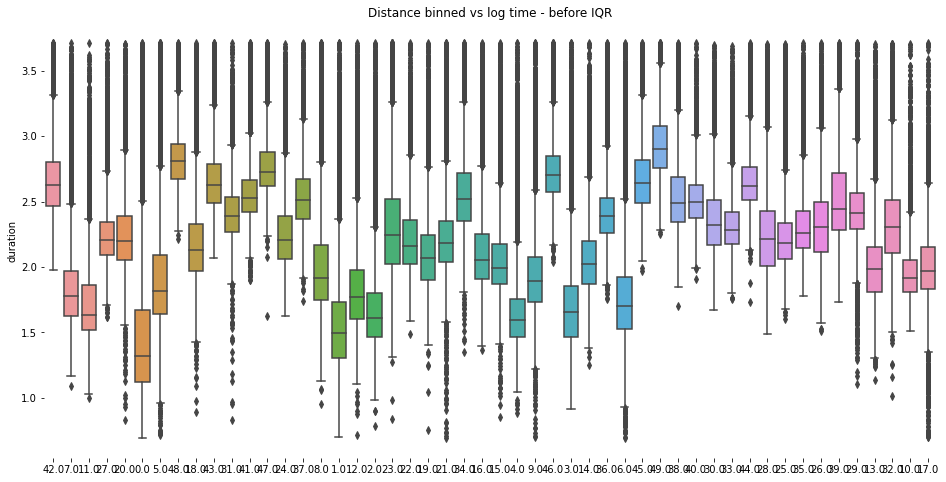

In [7]:
plt.figure(figsize=(16, 8))
plt.title('Distance binned vs log time - before IQR')
sns.boxplot(x=dist_binned.astype('str').flatten(), y=df['duration'])
sns.despine(left=True, bottom=True)

In [8]:
df['dist_bin'] = dist_binned
df['dist_bin'] = df['dist_bin'].astype('category')

In [9]:
iqrs = df.groupby('dist_bin').apply(lambda x: iqr(x['duration'])).reset_index()

In [10]:
quantiles = df.groupby('dist_bin')['duration'].quantile([.25, .75]).reset_index()
quantiles = quantiles.pivot(index='dist_bin', columns='level_1', values='duration').reset_index()

In [11]:
thresholds = pd.merge(quantiles, iqrs, on='dist_bin', how='left')
thresholds.columns = ['dist_bin', 'q1', 'q3', 'iqr']
thresholds['lower_thresh'] = thresholds['q1'] - thresholds['iqr']
thresholds['upper_thresh'] = thresholds['q3'] + thresholds['iqr']

In [12]:
df = pd.merge(df, thresholds[['dist_bin', 'lower_thresh', 'upper_thresh']], on='dist_bin', how='left')
df = df.loc[(df['duration'] >= df['lower_thresh']) & (df['duration'] <= df['upper_thresh'])]

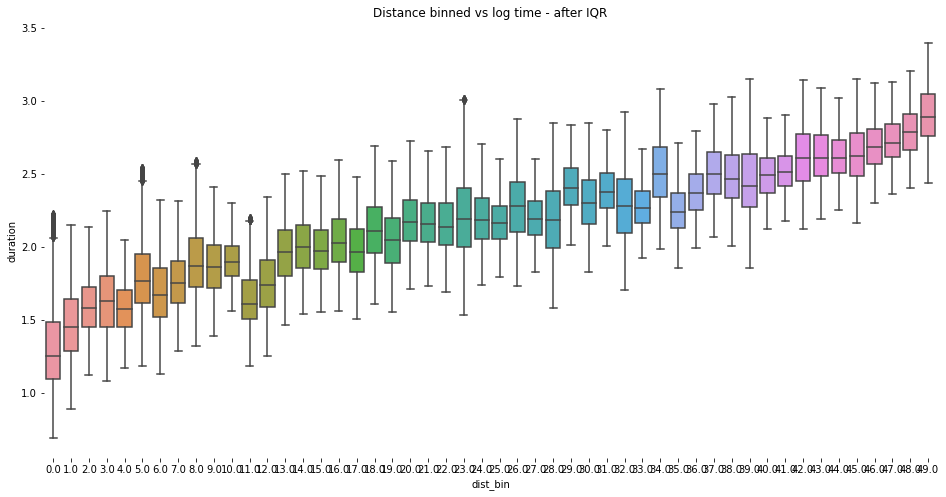

In [13]:
plt.figure(figsize=(16, 8))
plt.title('Distance binned vs log time - after IQR')
sns.boxplot(x=df['dist_bin'], y=df['duration'])
sns.despine(left=True, bottom=True)

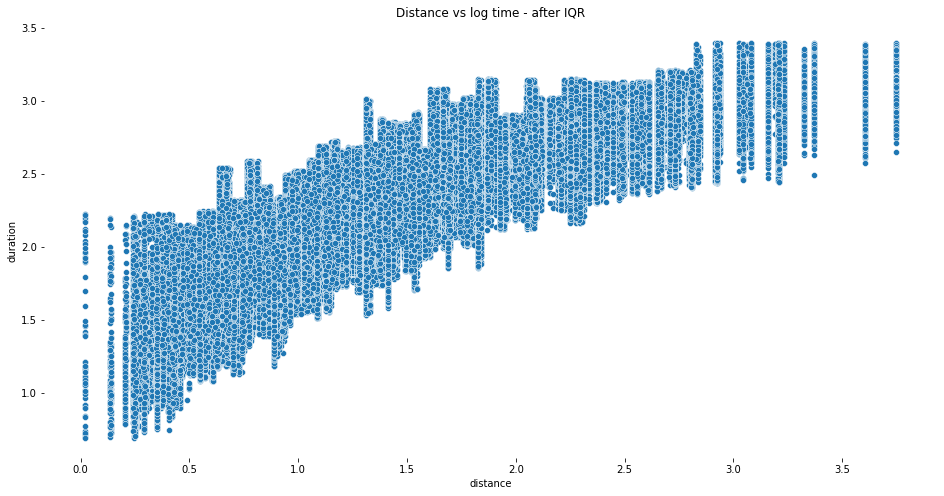

In [14]:
plt.figure(figsize=(16, 8))
plt.title('Distance vs log time - after IQR')
sns.scatterplot(x=df['distance'], y=df['duration'])
sns.despine(left=True, bottom=True)

In [15]:
df = df.drop(['Unnamed: 0', 'lower_thresh', 'upper_thresh'], axis=1)

In [16]:
df.head()

,duration,start_lat,start_long,start_alt,end_lat,end_long,end_alt,distance,dist_bin
0,2.932970,37.774814,-122.418954,15.628606,37.7766,-122.39547,2.835006,2.074195,42.0
1,2.988204,37.774814,-122.418954,15.628606,37.7766,-122.39547,2.835006,2.074195,42.0
2,2.976380,37.774814,-122.418954,15.628606,37.7766,-122.39547,2.835006,2.074195,42.0
3,2.977229,37.774814,-122.418954,15.628606,37.7766,-122.39547,2.835006,2.074195,42.0
4,2.619826,37.774814,-122.418954,15.628606,37.7766,-122.39547,2.835006,2.074195,42.0


Now response variable looks reasonable. So far this project has been all about thorough preprocessing, and this combined with fact that there is very few features means that final model should be relatively simple. Something along mean trip time for each distance bin. But again, this project is about stack.

## 2. Dataset split

I'm going to stick to the classic approach - save the test set and train with corss-validation. 20% of test set is going to be used for out-of-fold score

In [17]:
X = df.drop(['duration', 'dist_bin'], axis=1)
y = df['duration']

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
x_test.to_csv(os.path.join(output_data_path, 'x_test.csv'), index=False)
y_test.to_csv(os.path.join(output_data_path, 'y_test.csv'), index=False, header=True)

In [20]:
x_test.shape

(104587, 7)

In [21]:
x_oof = x_test.iloc[:(int(x_test.shape[0] * 0.2))]
y_oof = y_test.iloc[:(int(x_test.shape[0] * 0.2))]

In [22]:
# going to need those later
x_train_cp = x_train.copy()
y_train_cp = y_train.copy()

## 3. Models - baseline

Baselines are made with distance in standard form. Response is log transformed by default. I'm using minmax scaling for parametric models. I need to write my own cross val function since i have to calculate exp of preds to get back from log(duration) to duration. This has to be done before calculation MSE, so no pipeline this time

In [23]:
def cross_val(clf, x, y, x_test, y_test, cv, scale=True, boosting=False):
  cv_score = np.zeros(len(y))
  oof_score = np.zeros(len(y_test))
  kf = KFold(n_splits=cv, random_state=42, shuffle=True)
  
  for train_idx, val_idx in kf.split(x):
    x_train, y_train = x[train_idx], y[train_idx]
    x_valid, y_valid = x[val_idx], y[val_idx]
    
    if scale:
      scaler = MinMaxScaler()
      x_train = scaler.fit_transform(x_train)
      x_valid = scaler.transform(x_valid)
      x_test_cp = scaler.transform(x_test)
    
    else:
      x_test_cp = x_test
    
    if boosting:
      clf.fit(x_train, y_train, eval_set=(x_valid, y_valid),
              early_stopping_rounds=5)
    
    else:
      clf.fit(x_train, y_train)
    
    cv_score[val_idx] += clf.predict(x_valid)
    oof_score += clf.predict(x_test_cp) / cv
  
  # exp getting back to minutes
  cv_score = [np.expm1(x) for x in cv_score]
  oof_score = [np.expm1(x) for x in oof_score]
  y = [np.expm1(x) for x in y]
  y_test = [np.expm1(x) for x in y_test]
  
  cv_final_score = np.sqrt(mean_squared_error(y, cv_score))
  oof_final_score = np.sqrt(mean_squared_error(y_test, oof_score))
  
  return cv_final_score, oof_final_score

### 3.1. SGDRegressor - Stochastic Gradient Descent

I'm going to start with simple linear model fitted by minimizing a regularized empirical loss with SGD. L1 regularization is going to be used to allow parameter shrinkage to 0. All models will be evaluated with out-of-fold RMSE

In [24]:
sgd_clf = SGDRegressor(penalty='l1')
sgd_score = cross_val(sgd_clf, x_train.values, y_train.values, x_oof, y_oof, cv=10)

In [25]:
sgd_score

(2.4454399386630095, 2.437089128483603)

### 3.2. RandomForest

In [24]:
rf_clf = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=10)
rf_score = cross_val(rf_clf, x_train.values, y_train.values, x_oof, y_oof, cv=10, scale=False)

In [25]:
rf_score

(2.09933687060932, 2.0906766730736535)

### 3.3. Gradient boost

In [26]:
# for baseline going with sklearn API
lgbm_clf = lgb.LGBMRegressor(n_estimators=1000, max_depth=5, silent=True)
lgbm_score = cross_val(lgbm_clf, x_train.values, y_train.values, x_oof, y_oof, cv=10, scale=False, boosting=True)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]	valid_0's l2: 0.153447
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 0.132201
[3]	valid_0's l2: 0.114967
[4]	valid_0's l2: 0.10097
[5]	valid_0's l2: 0.0894541
[6]	valid_0's l2: 0.0800987
[7]	valid_0's l2: 0.0724851
[8]	valid_0's l2: 0.0663146
[9]	valid_0's l2: 0.0612182
[10]	valid_0's l2: 0.0570451
[11]	valid_0's l2: 0.0536645
[12]	valid_0's l2: 0.0508399
[13]	valid_0's l2: 0.0485387
[14]	valid_0's l2: 0.0466317
[15]	valid_0's l2: 0.0450804
[16]	valid_0's l2: 0.0437687
[17]	valid_0's l2: 0.0427179
[18]	valid_0's l2: 0.041831
[19]	valid_0's l2: 0.0410627
[20]	valid_0's l2: 0.0404554
[21]	valid_0's l2: 0.039914
[22]	valid_0's l2: 0.0394728
[23]	valid_0's l2: 0.0390793
[24]	valid_0's l2: 0.0387673
[25]	valid_0's l2: 0.0385008
[26]	valid_0's l2: 0.0382376
[27]	valid_0's l2: 0.0380284
[28]	valid_0's l2: 0.037816
[29]	valid_0's 

In [27]:
lgbm_score

(1.913464601741366, 1.9021707549351112)

## 4. Models - second iteration

Now i'm going to bin trip distance again and see if this makes any difference. Not going with 50 bins though, this would produce sparse matrix after one hot encoding. In first iteration I'm going to number encode bins preserving hierarchical nature of this feature. In second iteratiom I'm going to try one hot encoding

In [28]:
enc = KBinsDiscretizer(n_bins=10, encode='ordinal')
x_train['distance'] = enc.fit_transform(x_train['distance'].values.reshape(-1, 1))
x_train['distance'] = x_train['distance'].astype(int)
x_oof['distance'] = enc.transform(x_oof['distance'].values.reshape(-1, 1))
x_oof['distance'] = x_oof['distance'].astype('int')

/Users/rajesh/work/projects/learning/machine-learning/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/rajesh/work/projects/learning/machine-learning/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/rajesh/work/projects/learning/machine-learning/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: Set

### 4.1. SGDRegressor

In [29]:
sgd2_clf = SGDRegressor(penalty='l1')
sgd2_score = cross_val(sgd2_clf, x_train.values, y_train.values, x_oof, y_oof, cv=10)

In [30]:
sgd2_score

(2.320571067423458, 2.3173620542150104)

### 4.2. RandomForest

In [31]:
rf2_clf = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=10)
rf2_score = cross_val(rf2_clf, x_train.values, y_train.values, x_oof, y_oof, cv=10, scale=False)

In [32]:
rf2_score

(2.1900001998922596, 2.188278732064376)

### 4.3. Boosting

In [33]:
lgbm2_clf = lgb.LGBMRegressor(n_estimators=1000, max_depth=5, silent=True)
lgbm2_score = cross_val(lgbm2_clf, x_train.values, y_train.values, x_oof, y_oof, cv=10, scale=False, boosting=True)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]	valid_0's l2: 0.154183
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 0.133562
[3]	valid_0's l2: 0.116783
[4]	valid_0's l2: 0.103145
[5]	valid_0's l2: 0.0920848
[6]	valid_0's l2: 0.0830619
[7]	valid_0's l2: 0.0757031
[8]	valid_0's l2: 0.0697183
[9]	valid_0's l2: 0.0647788
[10]	valid_0's l2: 0.0607905
[11]	valid_0's l2: 0.0575183
[12]	valid_0's l2: 0.0547163
[13]	valid_0's l2: 0.0523563
[14]	valid_0's l2: 0.0504351
[15]	valid_0's l2: 0.0489145
[16]	valid_0's l2: 0.0476399
[17]	valid_0's l2: 0.0464516
[18]	valid_0's l2: 0.0455736
[19]	valid_0's l2: 0.0447363
[20]	valid_0's l2: 0.0440394
[21]	valid_0's l2: 0.0434347
[22]	valid_0's l2: 0.042907
[23]	valid_0's l2: 0.042477
[24]	valid_0's l2: 0.0421237
[25]	valid_0's l2: 0.041833
[26]	valid_0's l2: 0.041506
[27]	valid_0's l2: 0.0412518
[28]	valid_0's l2: 0.0409664
[29]	valid_0's 

In [34]:
lgbm2_score

(1.9137610320860141, 1.9014647562853821)

Seems like binning to ordinal works well with parametric model, but does not make difference in tree based ones. I'm going to try OHE approach and probably pick something since results are good at this point.

## 5. Models - third iteration

In [35]:
class RobustOneHotEncoder:

    def __init__(self):
        self.pos = 0
        self.categories = None

    def _get_categories(self, df, col):
        """

        :param df:
        :param col:
        :return:
        """
        self.pos = np.where(df.columns == col)[0][0]
        cats = sorted(df.iloc[:, self.pos].value_counts(dropna=True).index)

        return cats

    def fit(self, df, col):
        """

        :param df:
        :param col:
        :return:
        """
        assert col in df.columns
        self.categories = self._get_categories(df, col)

    def fit_transform(self, df, col):
        """

        :param df:
        :param col:
        :return:
        """
        assert col in df.columns
        self.categories = self._get_categories(df, col)
        t = pd.api.types.CategoricalDtype(categories=self.categories)
        labels = df.iloc[:, [self.pos]].astype(t)
        encoded = pd.concat([df, pd.get_dummies(labels)], axis=1)

        return encoded

    def transform(self, df):
        """

        :param df:
        :return:
        """
        t = pd.api.types.CategoricalDtype(categories=self.categories)
        labels = df.iloc[:, [self.pos]].astype(t)
        encoded = pd.concat([df, pd.get_dummies(labels)], axis=1)

        return encoded

In [36]:
ohe = RobustOneHotEncoder()
x_train = ohe.fit_transform(x_train, 'distance')
x_oof = ohe.transform(x_oof)

In [37]:
x_train = x_train.drop(['distance'], axis=1)
x_oof = x_oof.drop(['distance'], axis=1)

### 5.1 SGDRegressor

In [38]:
sgd3_clf = SGDRegressor(penalty='l1')
sgd3_score = cross_val(sgd3_clf, x_train.values, y_train.values, x_oof, y_oof, cv=10)

In [39]:
sgd3_score

(2.2853649333771657, 2.2851871242745876)

### 5.2. RandomForest

In [40]:
rf3_clf = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=10)
rf3_score = cross_val(rf3_clf, x_train.values, y_train.values, x_oof, y_oof, cv=10, scale=False)

In [41]:
rf3_score

(2.4241820767682247, 2.416547736596175)

### 5.3. Boosting

In [42]:
lgbm3_clf = lgb.LGBMRegressor(n_estimators=1000, max_depth=5, silent=True)
lgbm3_score = cross_val(lgbm3_clf, x_train.values, y_train.values, x_oof, y_oof, cv=10, scale=False, boosting=True)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]	valid_0's l2: 0.156651
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 0.137945
[3]	valid_0's l2: 0.123053
[4]	valid_0's l2: 0.109653
[5]	valid_0's l2: 0.0995925
[6]	valid_0's l2: 0.0902525
[7]	valid_0's l2: 0.0830567
[8]	valid_0's l2: 0.0773471
[9]	valid_0's l2: 0.0716242
[10]	valid_0's l2: 0.0672126
[11]	valid_0's l2: 0.0638899
[12]	valid_0's l2: 0.0611592
[13]	valid_0's l2: 0.0582623
[14]	valid_0's l2: 0.0563984
[15]	valid_0's l2: 0.0543033
[16]	valid_0's l2: 0.0527699
[17]	valid_0's l2: 0.051454
[18]	valid_0's l2: 0.0501674
[19]	valid_0's l2: 0.0493384
[20]	valid_0's l2: 0.0484426
[21]	valid_0's l2: 0.0477411
[22]	valid_0's l2: 0.0470206
[23]	valid_0's l2: 0.0465265
[24]	valid_0's l2: 0.0461078
[25]	valid_0's l2: 0.0455615
[26]	valid_0's l2: 0.0451193
[27]	valid_0's l2: 0.0448262
[28]	valid_0's l2: 0.0443377
[29]	valid_0

In [43]:
lgbm3_score

(1.9136790327962254, 1.901239192516069)

I've suspected drop in performance for non paramteric models after introducing OHE due to [this](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/). Basically decision tree models can handle categorical variables without one-hot encoding them. 

## 6. Hyperparams optimization

Based on baseline results, I've decided to go with non binned distance and Gradient Boost Decision Tree approach. To finish off this notebook I'm going to prepare clean datasets for Bayesian search

In [44]:
x_train = x_train_cp
y_train = y_train_cp

In [45]:
x_train.head()

,start_lat,start_long,start_alt,end_lat,end_long,end_alt,distance
488892,37.789756,-122.394643,3.633262,37.776619,-122.417385,16.152735,2.476302
490481,37.776619,-122.417385,16.152735,37.786305,-122.404966,12.183614,1.533845
278765,37.795392,-122.394203,2.596962,37.804770,-122.403234,2.659792,1.310756
371994,37.771058,-122.402717,3.039870,37.790302,-122.390637,2.818376,2.389468
337367,37.786978,-122.398108,7.070823,37.776617,-122.395260,2.990568,1.179335


In [46]:
y_train.head()

488892    2.541602
490481    1.976393
278765    2.034706
371994    2.708050
337367    1.992430
Name: duration, dtype: float64

In [47]:
y_train.shape

(418345,)

In [48]:
x_train.to_csv(os.path.join(output_data_path, 'x_train.csv'), index=False)
y_train.to_csv(os.path.join(output_data_path, 'y_train.csv'), index=False, header=True)